In [1]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, FOSCTTM
import scanpy as sc
from collections import Counter
from scipy.stats import entropy
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

C:\Users\49152\anaconda3\envs\scotplus\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
CUDNN version: 91002


In [3]:
BASE_DIR = "C:/Users/49152/Downloads/Multi-omics/"
SCOT_IN = os.path.join(BASE_DIR, "SCOT_plus/input")
RNA_FILE = os.path.join(SCOT_IN, "transcriptomics_for_SCOT.csv")
PROT_FILE = os.path.join(SCOT_IN, "proteomics_for_SCOT.csv")
RNA_META = os.path.join(SCOT_IN, "transcriptomics_metadata.csv")
PROT_META = os.path.join(SCOT_IN, "proteomics_metadata.csv")
OUT_DIR = os.path.join(BASE_DIR, "SCOT_plus/AGW_results")

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [5]:
#Load matrices and prepare sample×feature arrays
rna_df = pd.read_csv(RNA_FILE, index_col=0)
rna = rna_df.T.copy()
prot_df = pd.read_csv(PROT_FILE, index_col=0)
prot = prot_df.T.copy()
print("RNA shape (samples x genes):", rna.shape)
print("Prot shape (samples x proteins):", prot.shape)
#Sort samples for reproducibility
rna = rna.sort_index()
prot = prot.sort_index()

RNA shape (samples x genes): (82, 2000)
Prot shape (samples x proteins): (67, 1000)


In [6]:
rna_meta = pd.read_csv(RNA_META, index_col=0)
prot_meta = pd.read_csv(PROT_META, index_col=0)
merged_meta = pd.concat([rna_meta, prot_meta])
merged_meta = merged_meta[~merged_meta.index.duplicated(keep='first')]
print(merged_meta)

            Chip CellLine  DetectedGenes5  sizeFactor
SampleID                                             
05J_C10_D1   05J      C10          7758.0    2.367114
05J_C10_D3   05J      C10          6914.0    3.243054
05J_C10_D5   05J      C10          4084.0    0.164945
05J_C10_D7   05J      C10          4765.0    0.351075
05J_C10_D9   05J      C10          4902.0    0.668006
...          ...      ...             ...         ...
07J_SVEC_B4  07J     SVEC             NaN         NaN
07J_SVEC_B5  07J     SVEC             NaN         NaN
07J_SVEC_C3  07J     SVEC             NaN         NaN
07J_SVEC_C4  07J     SVEC             NaN         NaN
07J_SVEC_D6  07J     SVEC             NaN         NaN

[89 rows x 4 columns]


In [7]:
#Assign cell_type based on merged_meta['CellLine']
rna['cell_type'] = rna.index.map(merged_meta['CellLine'])
prot['cell_type'] = prot.index.map(merged_meta['CellLine'])

In [8]:
Counter(rna['cell_type']),Counter(prot['cell_type'])

(Counter({'C10': 43, 'SVEC': 39}), Counter({'SVEC': 36, 'C10': 31}))

In [9]:
#Retrieving numeric matrices
prot_mtx = prot.iloc[:, :-1]
rna_mtx = rna.iloc[:, :-1]
#Keep labels
rna_features = rna_mtx.columns
prot_features = prot_mtx.columns
rna_cells = rna_mtx.index
prot_cells = prot_mtx.index

In [10]:
#Simple mean-imputation per feature for proteomics
prot_mtx = prot_mtx.apply(lambda x: x.fillna(x.mean()), axis=0)

In [11]:
# L2-normalize per cell (row) to make RNA and protein scales comparable
rna_mtx = normalize(rna_mtx, axis=1).astype(np.float32)
prot_mtx = normalize(prot_mtx, axis=1).astype(np.float32)

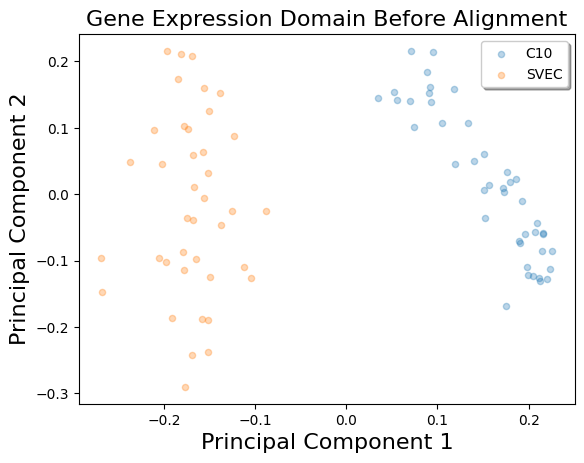

In [25]:
#RNA visualisation via PCA
label_array = np.array(rna['cell_type'].to_list())
unique_labels = np.unique(label_array)
rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx)
rna_2Dpca = rna_pca.transform(rna_mtx)

plt.figure()
for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dpca[subset, 0], rna_2Dpca[subset, 1], s=20, alpha=0.3, label=label)
plt.legend(loc='best', shadow=True)
plt.title('Gene Expression Domain Before Alignment', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.savefig(os.path.join(OUT_DIR, 'RNA_PCA_before_alignment.svg'), format='svg')
plt.show()

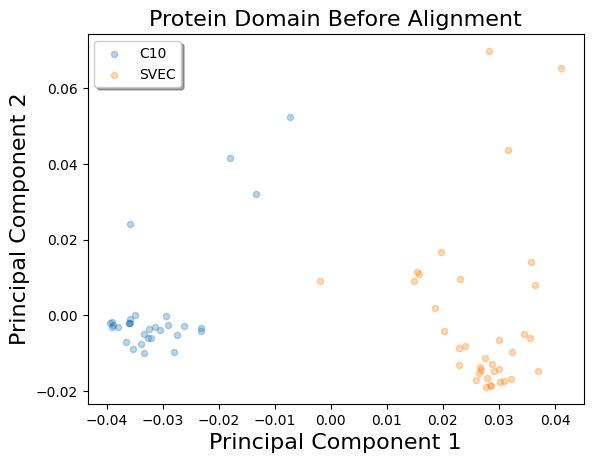

In [27]:
#Protein visualisation via PCA
label_array = np.array(prot['cell_type'].to_list())
unique_labels = np.unique(label_array)
prot_pca=PCA(n_components=2)
prot_2Dpca=prot_pca.fit_transform(prot_mtx)

plt.figure()
for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(prot_2Dpca[subset, 0], prot_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

plt.legend(loc='best', shadow=True)
plt.title('Protein Domain Before Alignment', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.savefig(os.path.join(OUT_DIR, 'Protein_PCA_before_alignment.svg'), format='svg')
plt.show()

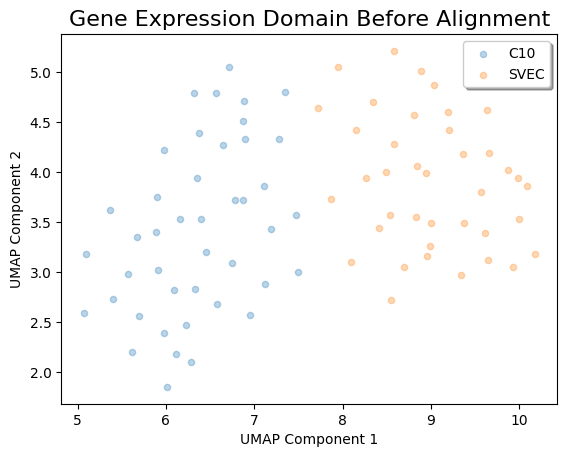

In [29]:
#RNA visualisation via UMAP
label_array = np.array(rna['cell_type'].to_list())
unique_labels = np.unique(label_array)
rna_umap=umap.UMAP(n_components=2, transform_seed=10)
rna_umap.fit(rna_mtx)
rna_2Dumap=rna_umap.transform(rna_mtx)

plt.figure()
for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dumap[subset, 0], rna_2Dumap[subset, 1], s=20, alpha=0.3, label=label)

plt.legend(loc='best', shadow=True)
plt.title('Gene Expression Domain Before Alignment', fontsize=16)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.savefig(os.path.join(OUT_DIR, 'RNA_UMAP_before_alignment.svg'), format='svg')
plt.show()

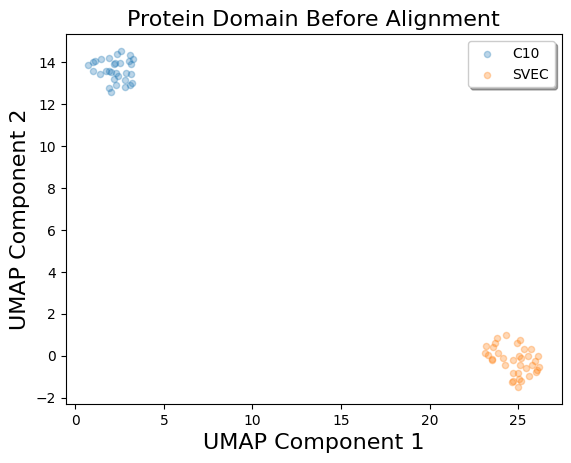

In [31]:
#Protein visualisation via UMAP
label_array = np.array(prot['cell_type'].to_list())

unique_labels = np.unique(label_array)
prot_umap=umap.UMAP(n_components=2)
prot_2Dumap=prot_umap.fit_transform(prot_mtx)

plt.figure()
for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(prot_2Dumap[subset, 0], prot_2Dumap[subset, 1], s=20, alpha=0.3, label=label)

plt.legend(loc='best', shadow=True)
plt.title('Protein Domain Before Alignment', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=16)
plt.ylabel('UMAP Component 2', fontsize=16)
plt.savefig(os.path.join(OUT_DIR, 'Protein_UMAP_before_alignment.svg'), format='svg')
plt.show()

In [33]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3, device=device)

In [35]:
# knn connectivity distance
D_prot_knn, D_rna_knn = torch.from_numpy(compute_graph_distances(prot_mtx, n_neighbors=5, mode='connectivity').astype('float32')).to(device), torch.from_numpy(compute_graph_distances(rna_mtx, n_neighbors=5, mode='connectivity').astype('float32')).to(device)

BCD Iteration 1 - Loss: 0.009321, 0.009322
BCD Iteration 2 - Loss: 0.011314, 0.011315
BCD Iteration 3 - Loss: 0.011651, 0.011652
BCD Iteration 4 - Loss: 0.011706, 0.011707
BCD Iteration 5 - Loss: 0.012017, 0.012018
BCD Iteration 6 - Loss: 0.012284, 0.012285
BCD Iteration 7 - Loss: 0.012290, 0.012291
BCD Iteration 8 - Loss: 0.012281, 0.012282
BCD Iteration 9 - Loss: 0.012504, 0.012505
BCD Iteration 10 - Loss: 0.012754, 0.012755
BCD Iteration 11 - Loss: 0.012753, 0.012754
BCD Iteration 12 - Loss: 0.012911, 0.012912
BCD Iteration 13 - Loss: 0.013111, 0.013112
BCD Iteration 14 - Loss: 0.012539, 0.012540
BCD Iteration 15 - Loss: 0.012287, 0.012287
BCD Iteration 1 - Loss: 0.011688, 0.011697
BCD Iteration 2 - Loss: 0.012590, 0.012598
BCD Iteration 3 - Loss: 0.012779, 0.012787
BCD Iteration 4 - Loss: 0.013152, 0.013161
BCD Iteration 5 - Loss: 0.013289, 0.013297
BCD Iteration 6 - Loss: 0.013290, 0.013299
BCD Iteration 7 - Loss: 0.013270, 0.013278
BCD Iteration 8 - Loss: 0.013226, 0.013234
BCD I

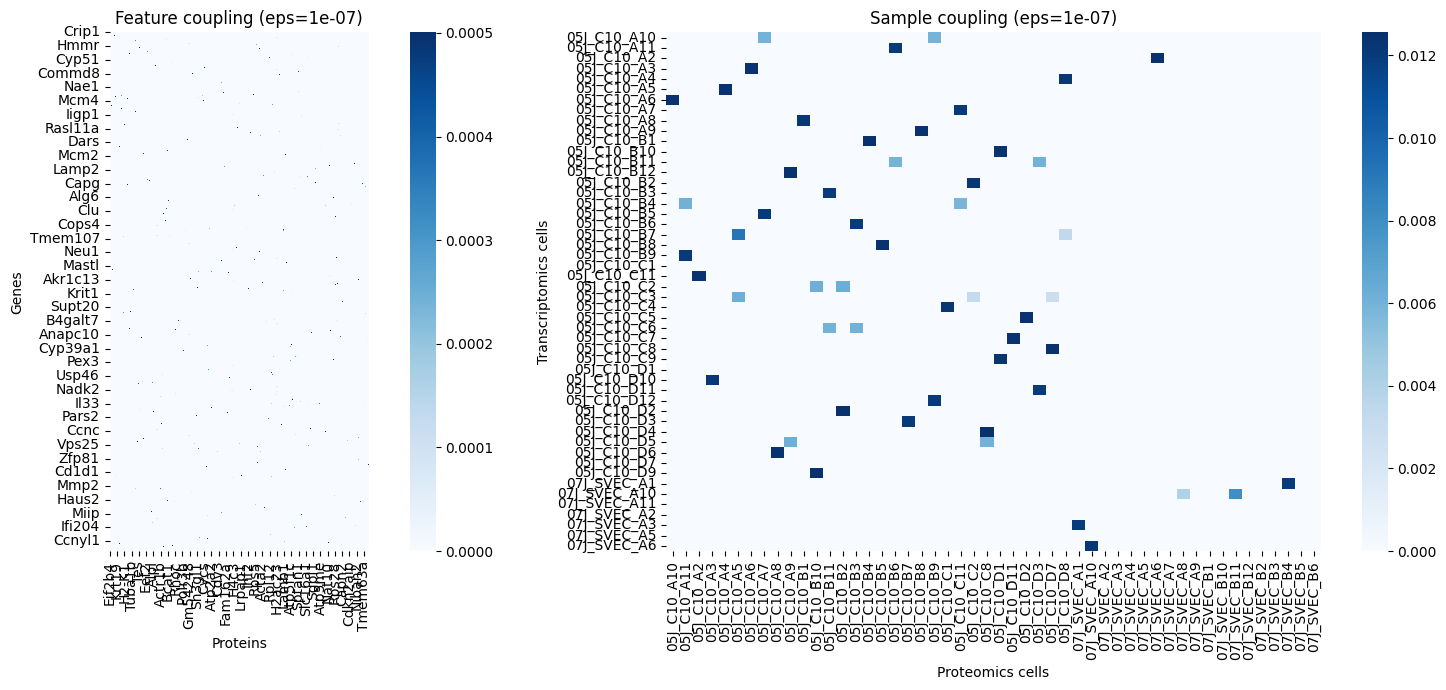

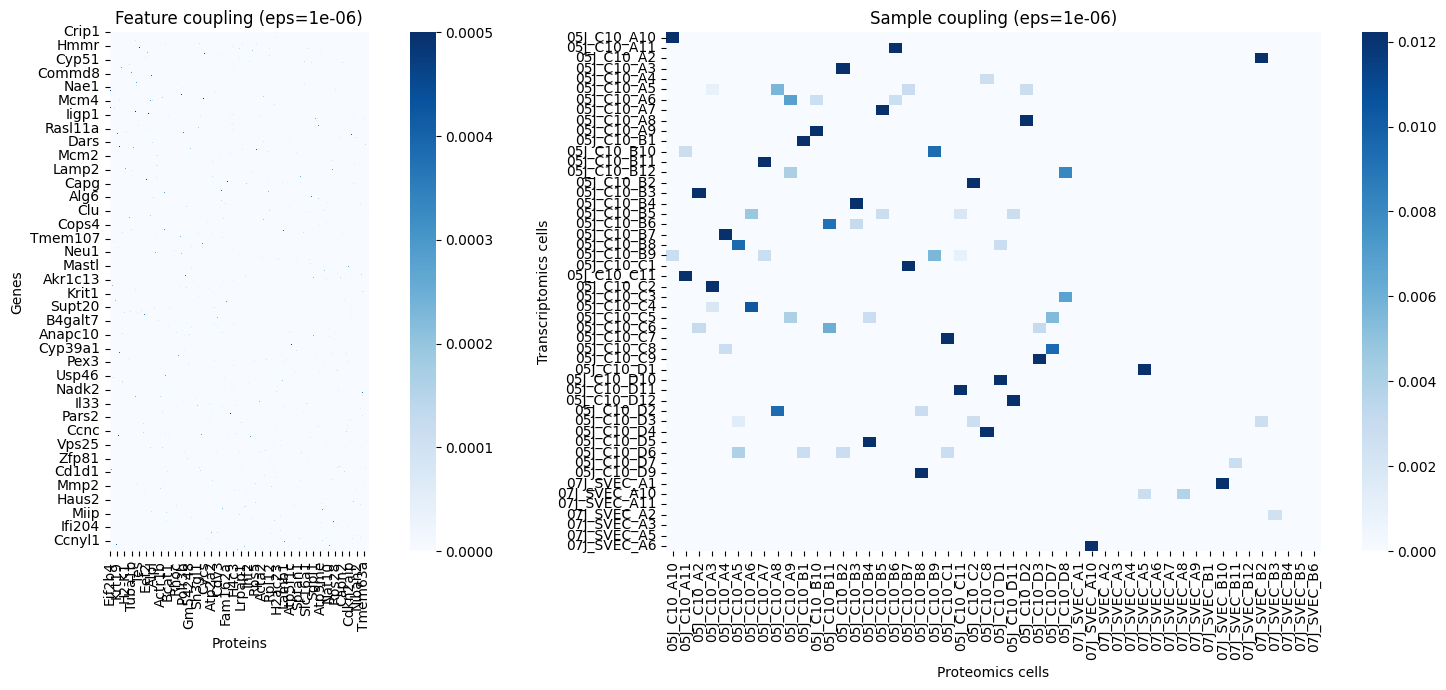

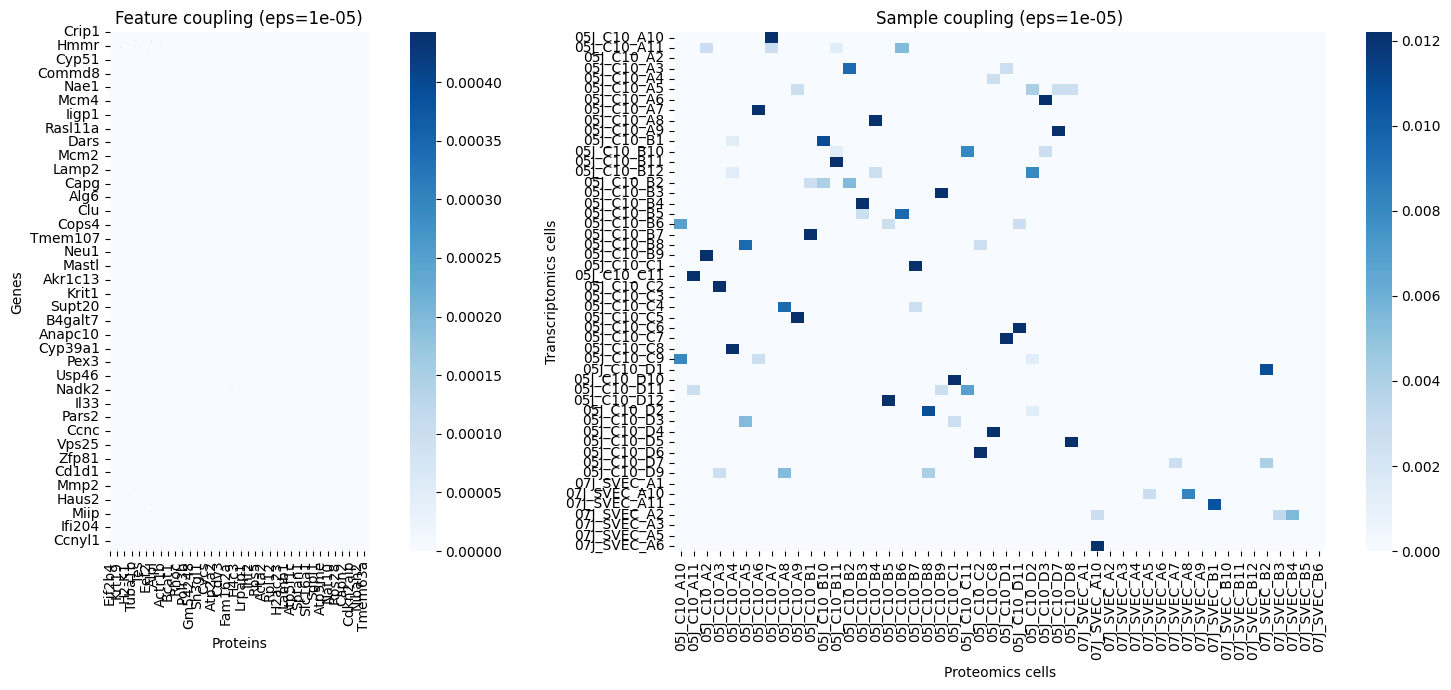

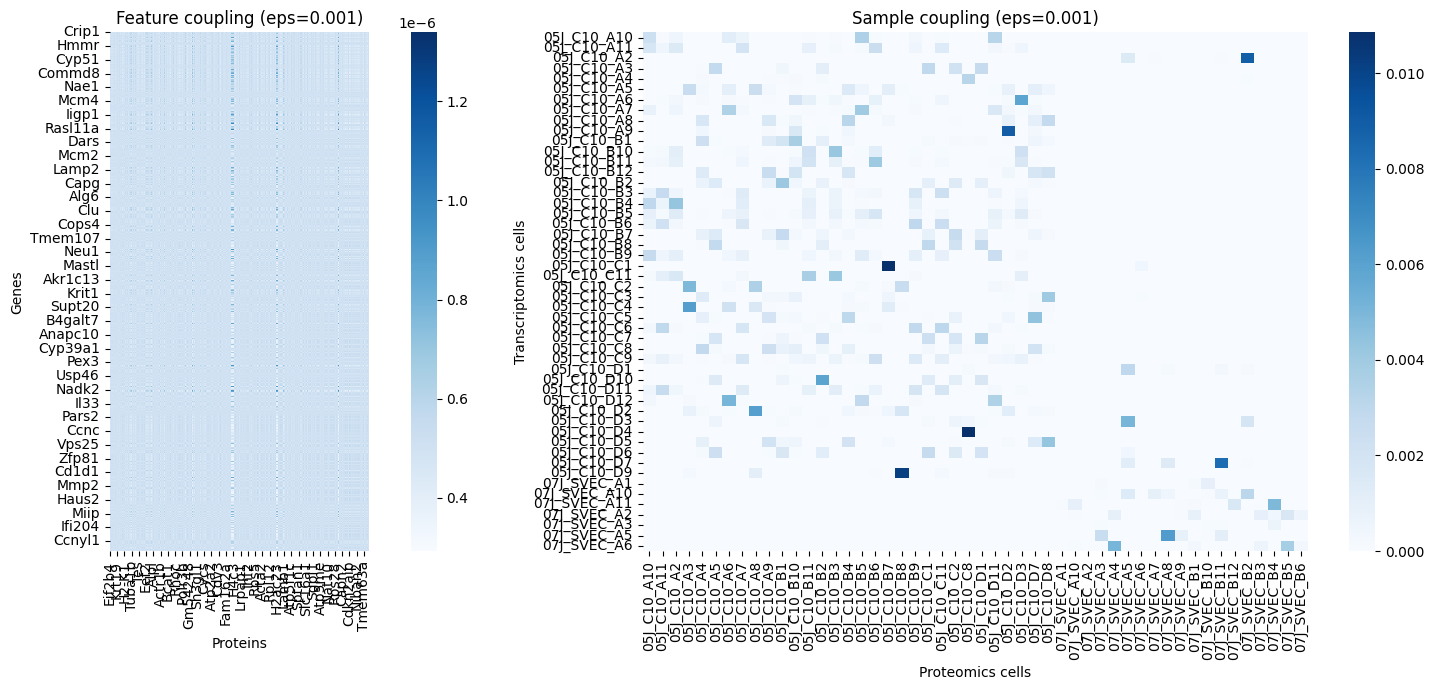

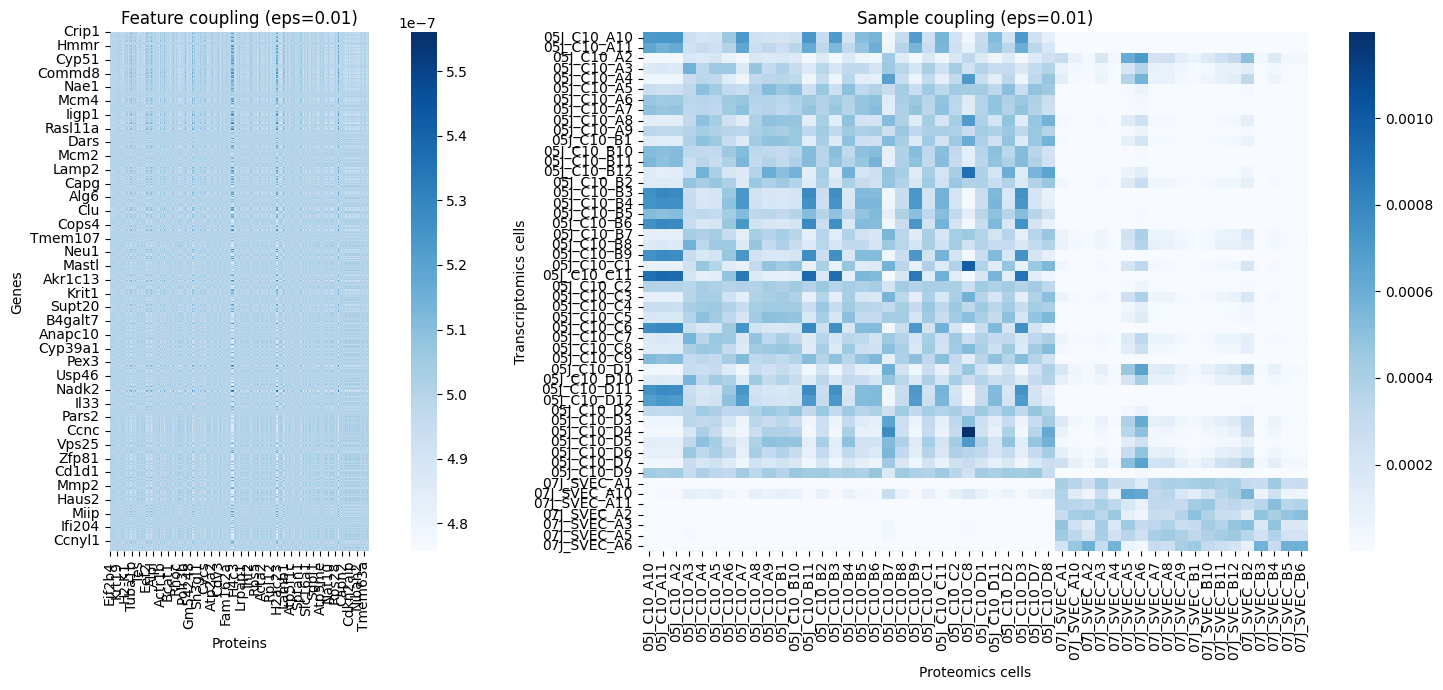

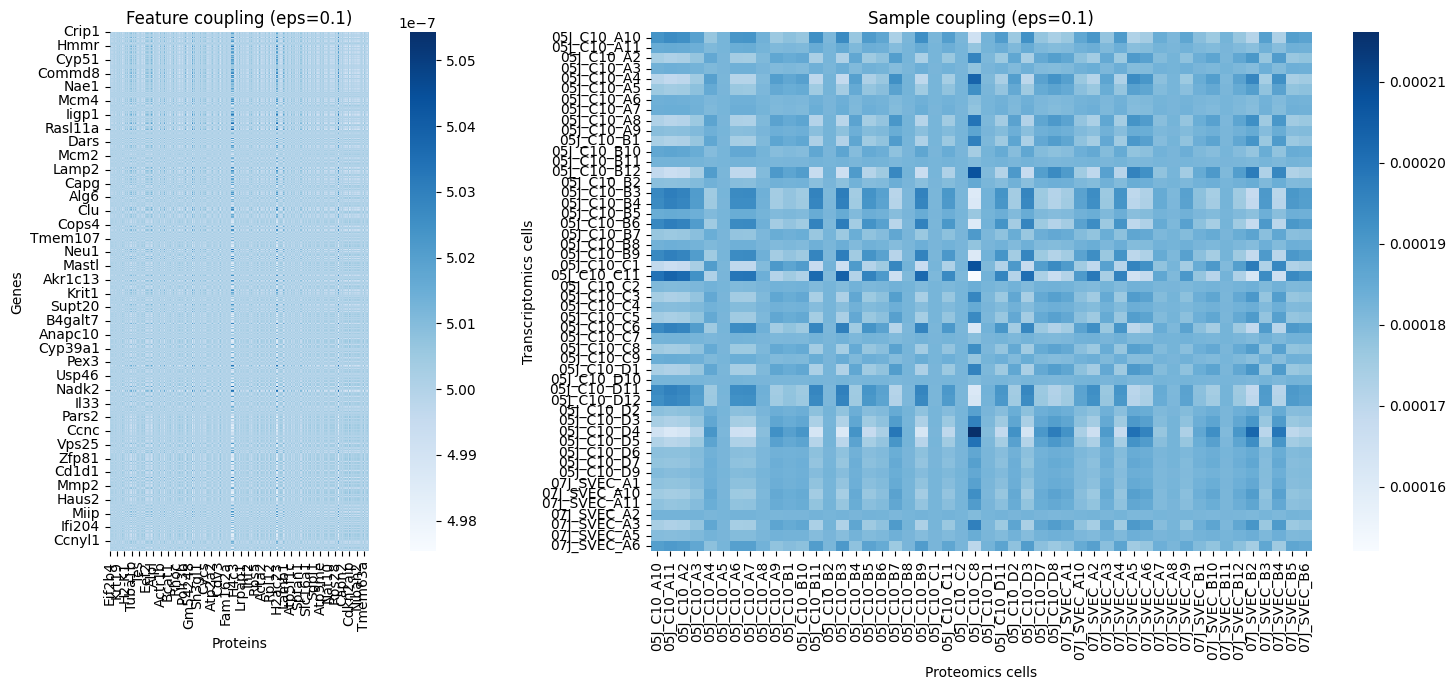

In [37]:
#Epsilon evaluation, grid search
eps_grid = [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1] #Adjust the grid to try out different value sets
alpha = 0.5 #Adjust alpha for the weight of features coupling, 1=UGW, 0=UCOOT, for MOFA+ application
pi_samp_list = []
pi_feat_list = []

for eps in eps_grid:
    # Run AGW alignment
    pi_samp, _, pi_feat = scot.agw(rna_mtx, prot_mtx, D_rna_knn, D_prot_knn, alpha=alpha, eps=eps, verbose=True)
    pi_samp_list.append(pi_samp)
    pi_feat_list.append(pi_feat)

#Heatmap plotting
for pi_feat, pi_samp, eps in zip(pi_feat_list, pi_samp_list, eps_grid):
    #Move to CPU if tensor
    pi_feat_np = pi_feat.cpu().numpy() if hasattr(pi_feat, "cpu") else np.array(pi_feat)
    pi_samp_np = pi_samp.cpu().numpy() if hasattr(pi_samp, "cpu") else np.array(pi_samp)
    
    #Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    #Feature coupling heatmap
    sns.heatmap(pd.DataFrame(pi_feat_np, index=rna_features, columns=prot_features),cmap='Blues', square=True, ax=ax1)
    ax1.set_title(f'Feature coupling (eps={eps})')
    ax1.set_xlabel('Proteins')
    ax1.set_ylabel('Genes')
    
    #Sample coupling heatmap
    n_plot = min(50, pi_samp_np.shape[0], pi_samp_np.shape[1])
    sns.heatmap(pi_samp_np[:n_plot, :n_plot], xticklabels=prot_cells[:n_plot], yticklabels=rna_cells[:n_plot], cmap='Blues', ax=ax2)
    ax2.set_title(f'Sample coupling (eps={eps})')
    ax2.set_xlabel('Proteomics cells')
    ax2.set_ylabel('Transcriptomics cells')
    
    plt.tight_layout()
    plt.show()

In [40]:
#Define epsilon, based on the grid search results
eps = 4.5e-4

True shared sample count: 60
(60,) (60,)
BCD Iteration 1 - Loss: 0.000522, 0.000528
BCD Iteration 2 - Loss: 0.000522, 0.000528
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.4454802259887006 for alpha 0.0


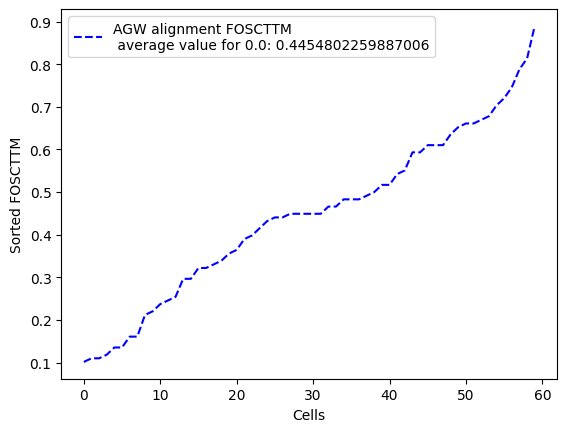

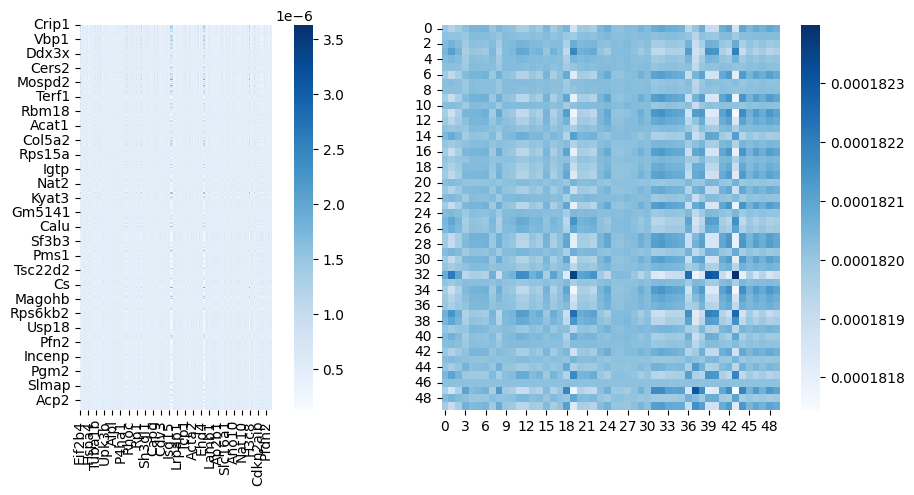

BCD Iteration 1 - Loss: 0.003697, 0.004699
BCD Iteration 2 - Loss: 0.003698, 0.004699
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.2912429378531074 for alpha 0.11


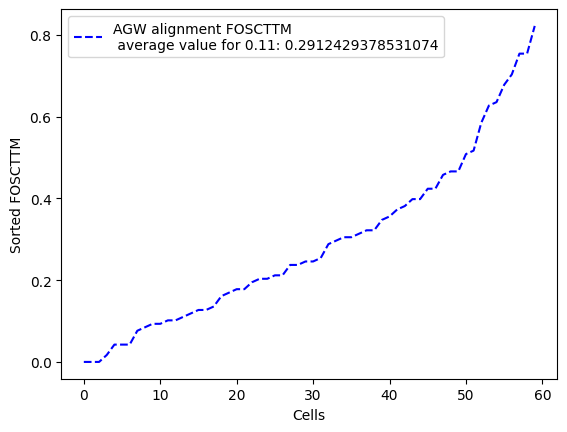

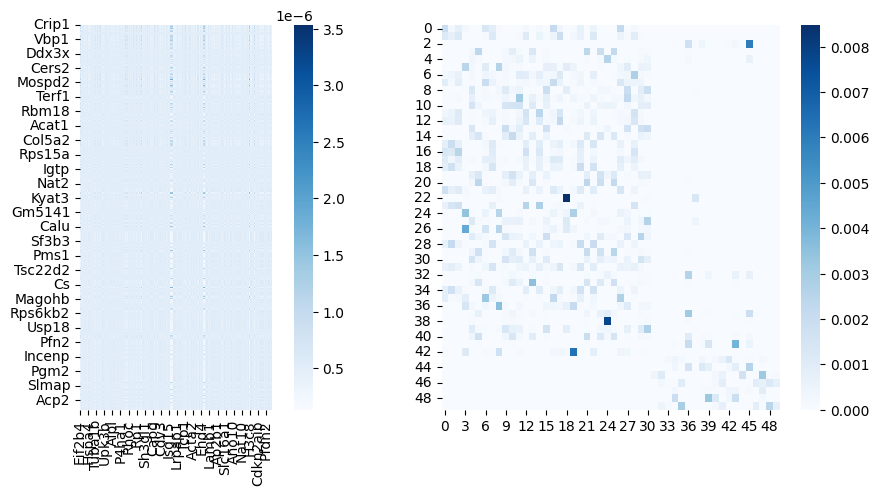

BCD Iteration 1 - Loss: 0.006409, 0.007901
BCD Iteration 2 - Loss: 0.006398, 0.007899
BCD Iteration 3 - Loss: 0.006398, 0.007898
BCD Iteration 4 - Loss: 0.006398, 0.007898
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.3016949152542373 for alpha 0.22


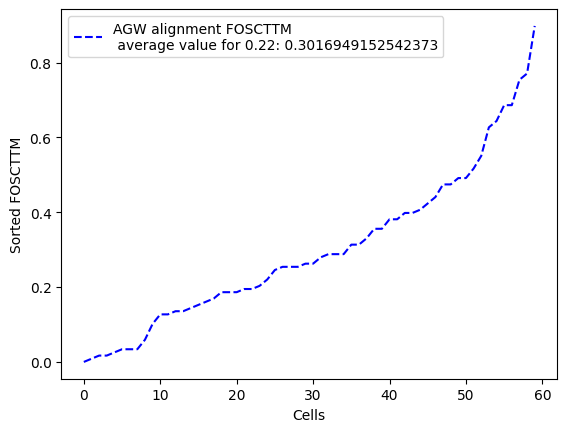

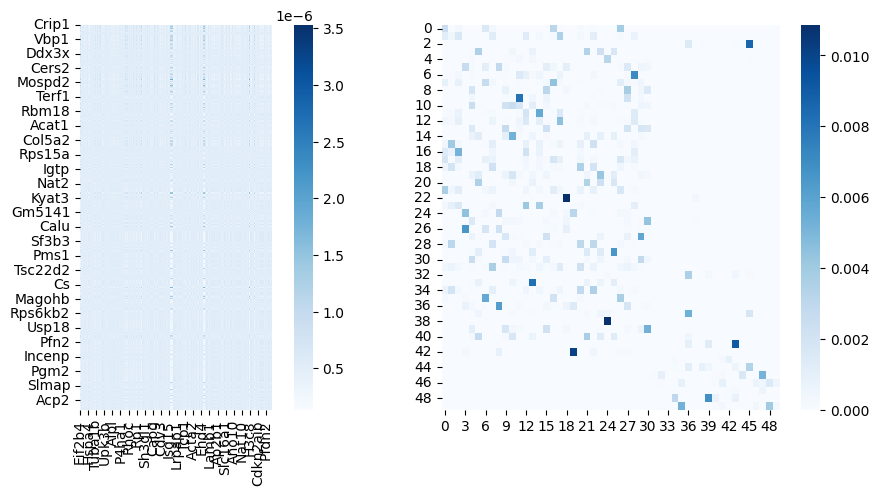

BCD Iteration 1 - Loss: 0.009129, 0.010987
BCD Iteration 2 - Loss: 0.009087, 0.010966
BCD Iteration 3 - Loss: 0.009085, 0.010961
BCD Iteration 4 - Loss: 0.009066, 0.010956
BCD Iteration 5 - Loss: 0.009061, 0.010953
BCD Iteration 6 - Loss: 0.009061, 0.010954
BCD Iteration 7 - Loss: 0.009062, 0.010955
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.31186440677966104 for alpha 0.33


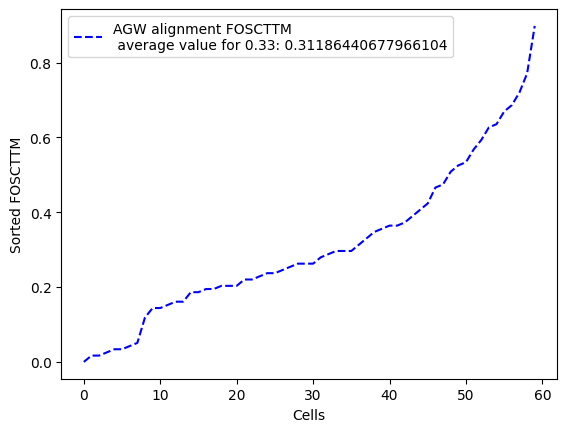

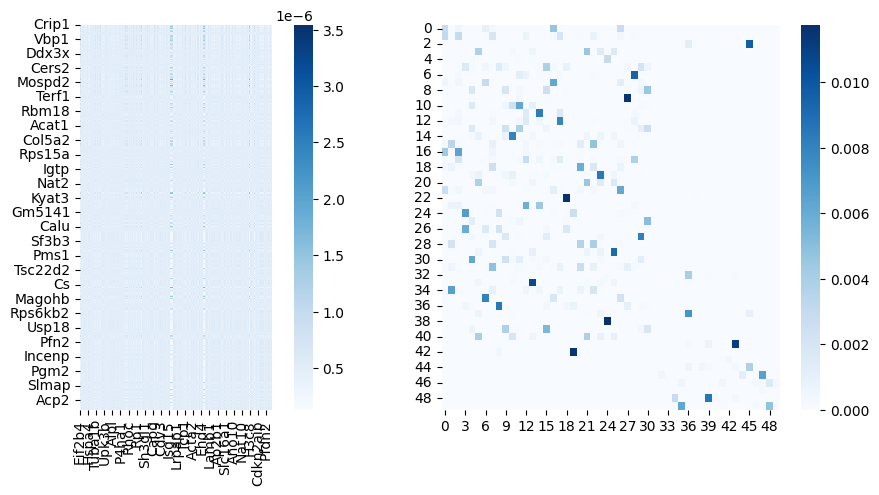

BCD Iteration 1 - Loss: 0.011849, 0.014020
BCD Iteration 2 - Loss: 0.011772, 0.013986
BCD Iteration 3 - Loss: 0.011766, 0.013984
BCD Iteration 4 - Loss: 0.011766, 0.013984
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.3149717514124294 for alpha 0.44


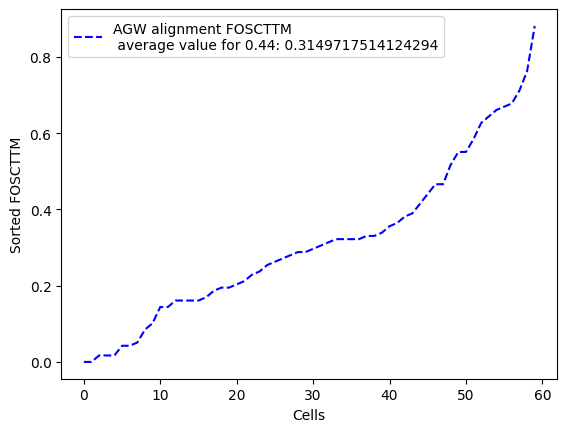

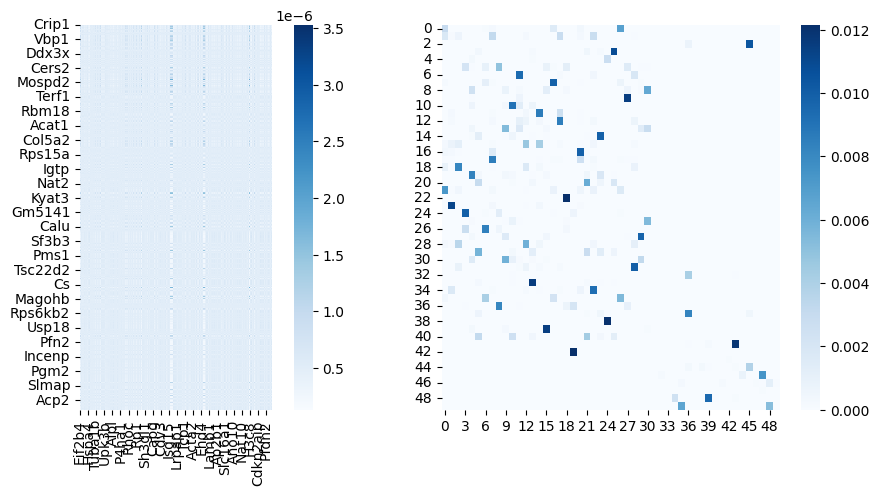

BCD Iteration 1 - Loss: 0.014810, 0.017217
BCD Iteration 2 - Loss: 0.014636, 0.017091
BCD Iteration 3 - Loss: 0.014633, 0.017091
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.3100282485875707 for alpha 0.55


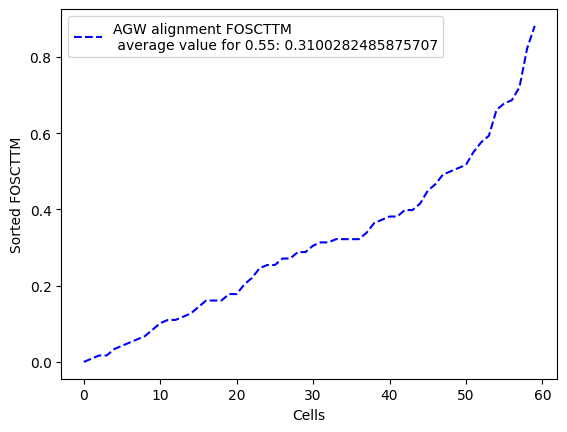

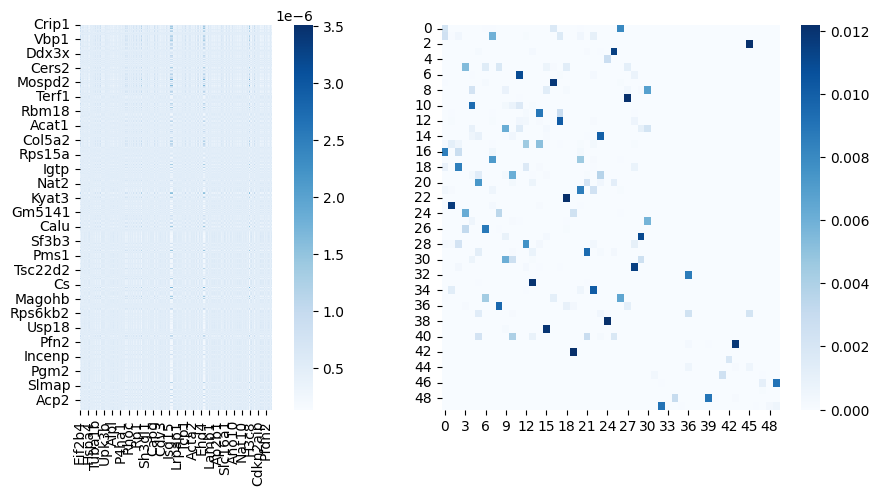

BCD Iteration 1 - Loss: 0.017554, 0.020228
BCD Iteration 2 - Loss: 0.017444, 0.020143
BCD Iteration 3 - Loss: 0.017437, 0.020139
BCD Iteration 4 - Loss: 0.017438, 0.020140
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.30466101694915254 for alpha 0.66


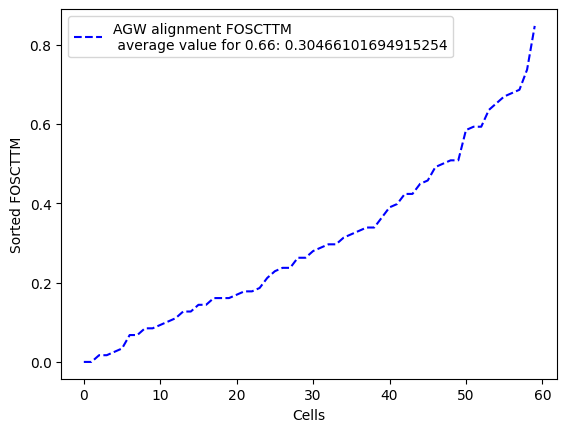

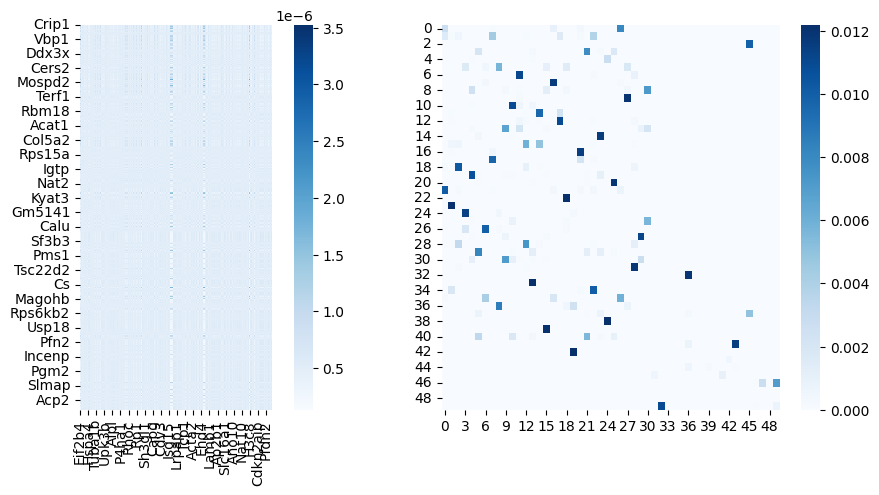

BCD Iteration 1 - Loss: 0.020277, 0.023158
BCD Iteration 2 - Loss: 0.020247, 0.023140
BCD Iteration 3 - Loss: 0.020202, 0.023103
BCD Iteration 4 - Loss: 0.020163, 0.023069
BCD Iteration 5 - Loss: 0.020123, 0.023041
BCD Iteration 6 - Loss: 0.020111, 0.023034
BCD Iteration 7 - Loss: 0.020106, 0.023030
BCD Iteration 8 - Loss: 0.020086, 0.023019
BCD Iteration 9 - Loss: 0.020083, 0.023019
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.3025423728813559 for alpha 0.77


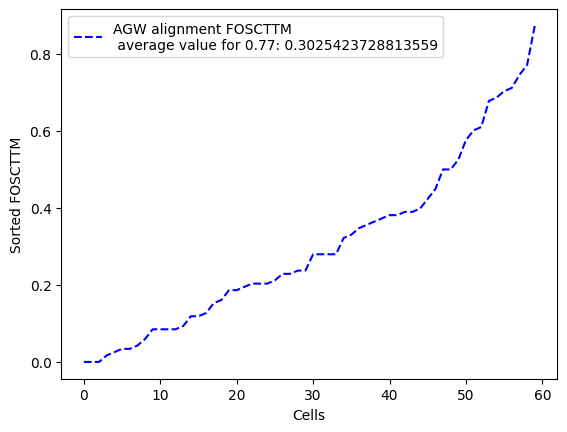

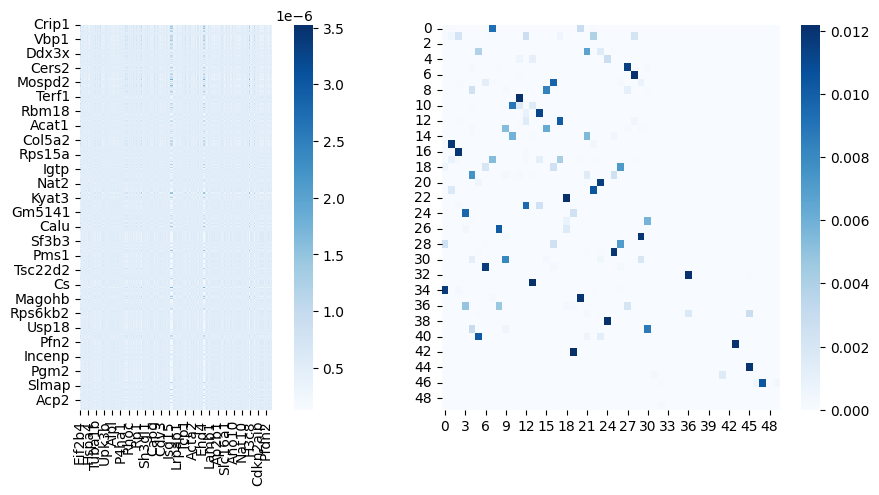

BCD Iteration 1 - Loss: 0.023019, 0.026109
BCD Iteration 2 - Loss: 0.022972, 0.026090
BCD Iteration 3 - Loss: 0.022950, 0.026071
BCD Iteration 4 - Loss: 0.022956, 0.026075
BCD Iteration 5 - Loss: 0.022948, 0.026076
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.29816384180790956 for alpha 0.88


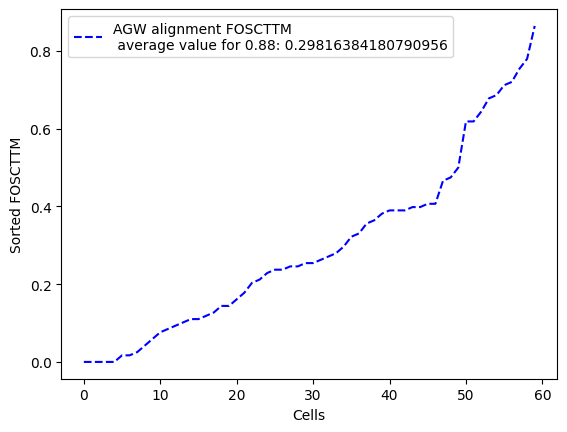

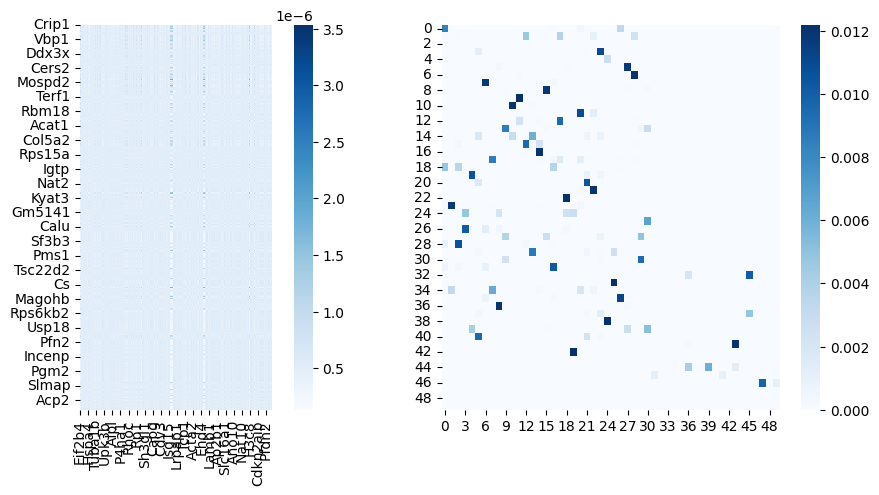

BCD Iteration 1 - Loss: 0.025846, 0.029159
BCD Iteration 2 - Loss: 0.025754, 0.029085
BCD Iteration 3 - Loss: 0.025765, 0.029098
BCD Iteration 4 - Loss: 0.025763, 0.029097
BCD Iteration 5 - Loss: 0.025762, 0.029095
BCD Iteration 6 - Loss: 0.025763, 0.029097
BCD Iteration 7 - Loss: 0.025761, 0.029095
BCD Iteration 8 - Loss: 0.025762, 0.029098
BCD Iteration 9 - Loss: 0.025759, 0.029094
BCD Iteration 10 - Loss: 0.025760, 0.029095
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.3001412429378531 for alpha 0.99


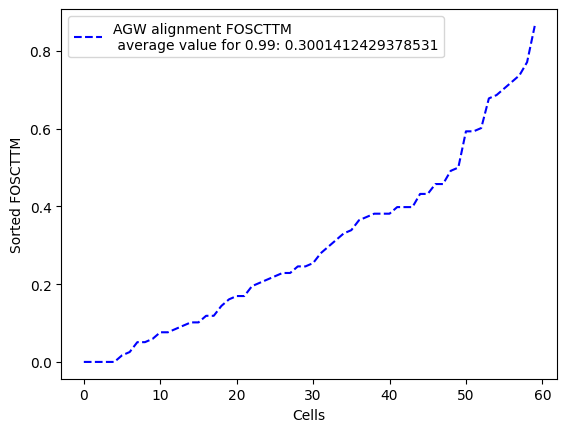

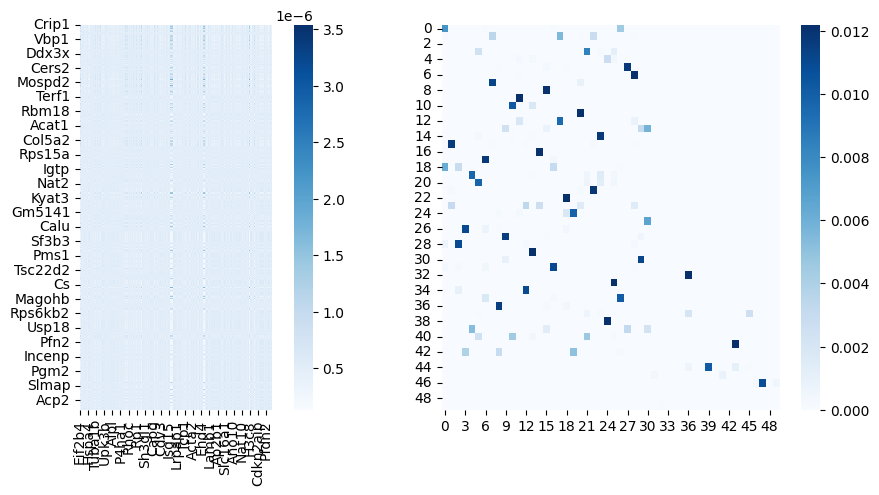

In [42]:
#Grid definition from 0 (graph only) to 1 (features only)
alpha_grid = np.linspace(0, 0.99, 10)
pi_samp_dt = {}
pi_feat_dt = {}

#Find sample IDs that exist in both omics
common_true = sorted(set(rna_cells).intersection(set(prot_cells)))
print(f"True shared sample count: {len(common_true)}")

#Map to index order
rna_common_idx = np.array([list(rna_cells).index(sid) for sid in common_true])
prot_common_idx = np.array([list(prot_cells).index(sid) for sid in common_true])
print(rna_common_idx.shape, prot_common_idx.shape)

#Grid search
for val in alpha_grid:
    pi_samp_dt[val], _, pi_feat_dt[val] = scot.agw(rna_mtx, prot_mtx, D_rna_knn, D_prot_knn,alpha=val, eps=eps, verbose=True)
    aligned_rna = get_barycentre(prot_mtx, pi_samp_dt[val], device = device)
    rna_common = aligned_rna.cpu().numpy()[rna_common_idx, :]
    prot_common = prot_mtx[prot_common_idx, :]
    print(rna_common.shape, prot_common.shape)
    fracs = FOSCTTM(prot_common, rna_common)
    print("Mean FOSCTTM:", np.mean(fracs), "for alpha", val)
    legend_label="AGW alignment FOSCTTM \n average value for {0}: ".format(val)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    pi_feat_cpu = pi_feat_dt[val].detach().cpu().numpy()
    sns.heatmap(pd.DataFrame(pi_feat_cpu,index=rna.columns[0:2000],columns=prot.columns[0:1000]),ax=ax1,cmap="Blues",square=True)
    #sns.heatmap(pd.DataFrame(pi_feat_dt[val], index=rna.columns, columns=prot.columns), ax=ax1, cmap='Blues', square=True)
    # looking at a corner to get a sense
    pi_samp_cpu = pi_samp_dt[val].detach().cpu().numpy()
    sns.heatmap(pd.DataFrame(pi_samp_cpu[:50, :50]),cmap='Blues')
    plt.show()

In [43]:
#Define alpha
alpha = 0.11

In [46]:
pi_samp, _, pi_feat = scot.agw(rna_mtx, prot_mtx, D_rna_knn, D_prot_knn, alpha=alpha, eps=eps, verbose=True)

BCD Iteration 1 - Loss: 0.003697, 0.004699
BCD Iteration 2 - Loss: 0.003698, 0.004699



Running FOSCTTM evaluation...
True shared sample count: 60
Shapes: (60, 1000) (60, 1000)
Mean FOSCTTM: 0.2912429378531074
Random baseline: 0.45988700564971746


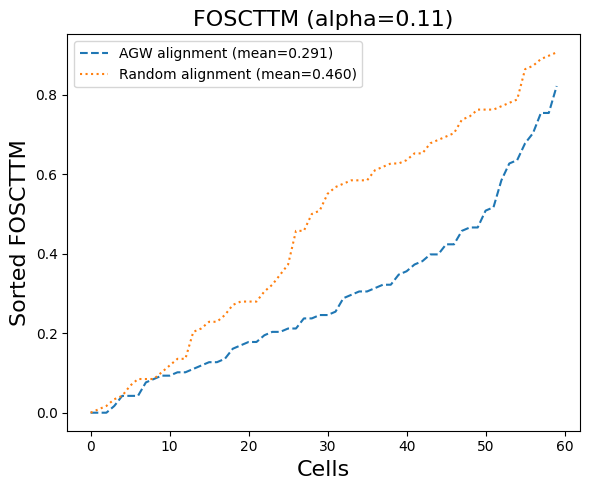

In [47]:
#FOSCTTM evaluation (alpha = 0.11)
print("\nRunning FOSCTTM evaluation...")
#Identify shared cells
common_true = sorted(set(rna_cells).intersection(set(prot_cells)))
print("True shared sample count:", len(common_true))
rna_common_idx = np.array([list(rna_cells).index(s) for s in common_true])
prot_common_idx = np.array([list(prot_cells).index(s) for s in common_true])

#Barycentric projection: RNA → protein space
aligned_rna = get_barycentre(prot_mtx, pi_samp, device=device)
rna_common = aligned_rna.detach().cpu().numpy()[rna_common_idx, :]
prot_common = prot_mtx[prot_common_idx, :]
print("Shapes:", rna_common.shape, prot_common.shape)

#Compute FOSCTTM
fracs = FOSCTTM(prot_common, rna_common)
mean_fos = np.mean(fracs)

#Random baseline
perm = np.random.permutation(len(prot_common))
rand_fracs = FOSCTTM(prot_common[perm], rna_common)
mean_rand = np.mean(rand_fracs)
print("Mean FOSCTTM:", mean_fos)
print("Random baseline:", mean_rand)

#Plotting
plt.figure(figsize=(6,5))
plt.plot(np.arange(len(fracs)),
         np.sort(fracs),
         linestyle="--",
         label=f"AGW alignment (mean={mean_fos:.3f})")
plt.plot(np.arange(len(rand_fracs)),
         np.sort(rand_fracs),
         linestyle=":",
         label=f"Random alignment (mean={mean_rand:.3f})")

plt.xlabel("Cells", fontsize=16)
plt.ylabel("Sorted FOSCTTM", fontsize=16)
plt.title(f"FOSCTTM (alpha={alpha})", fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"FOSCTTM_alpha_{alpha}.svg"), format="svg")
plt.show()

Evaluation & visualization

In [51]:
#Be careful for the transpose, this is actually to compute the alignment
aligned_rna_in_prot_space = get_barycentre(
    rna_mtx,      # RNA features
    pi_samp.T,    # protein rows × RNA columns
    device=device)
rna_mtx.shape, aligned_rna_in_prot_space.shape

((82, 2000), torch.Size([67, 2000]))

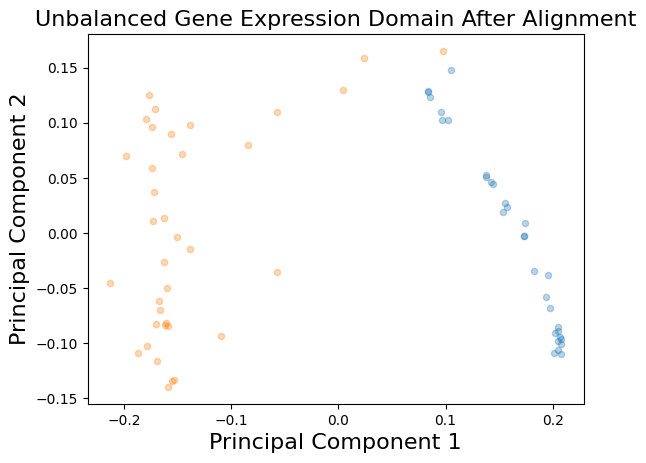

In [53]:
#RNA after alignment, PCA
Xrna_integrated=rna_mtx
Yprot_subsamp_integrated=aligned_rna_in_prot_space.detach().cpu().numpy()
concatenated=np.concatenate((Xrna_integrated,Yprot_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yprot_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['cell_type'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yprot_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yprot_subsamp_integrated_pc[mask, 0], Yprot_subsamp_integrated_pc[mask, 1], s=20, alpha=0.3, label = label)
    
plt.title('Unbalanced Gene Expression Domain After Alignment', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.show()

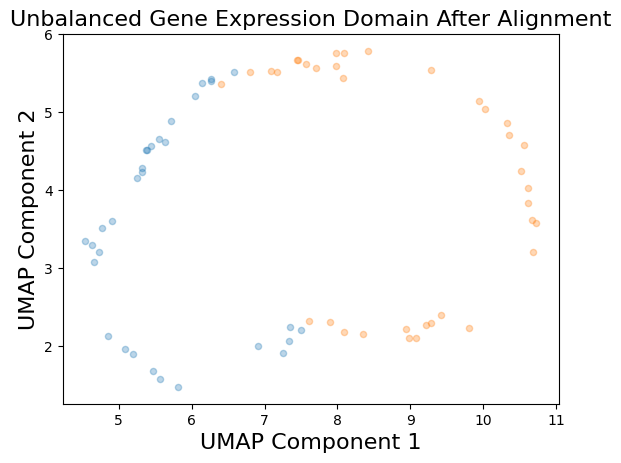

In [55]:
#RNA after alignment, UMAP
Xrna_integrated=rna_mtx
Yprot_subsamp_integrated=aligned_rna_in_prot_space.detach().cpu().numpy()
concatenated=np.concatenate((Xrna_integrated,Yprot_subsamp_integrated), axis=0)

concatenated_umap=rna_umap.transform(concatenated)
Xrna_integrated_umap=concatenated_umap[0:Xrna_integrated.shape[0],:]
Yprot_subsamp_integrated_umap=concatenated_umap[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['cell_type'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_umap = np.concatenate((Xrna_integrated_umap,Yprot_subsamp_integrated_umap), axis=0)
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yprot_subsamp_integrated_umap[mask, 0], Yprot_subsamp_integrated_umap[mask, 1], s=20, alpha=0.3, label = label)
    
    
plt.title('Unbalanced Gene Expression Domain After Alignment', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=16)
plt.ylabel('UMAP Component 2', fontsize=16)
plt.show()

C:\Users\49152\AppData\Local\Temp\ipykernel_13468\2436711042.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(unique_labels))


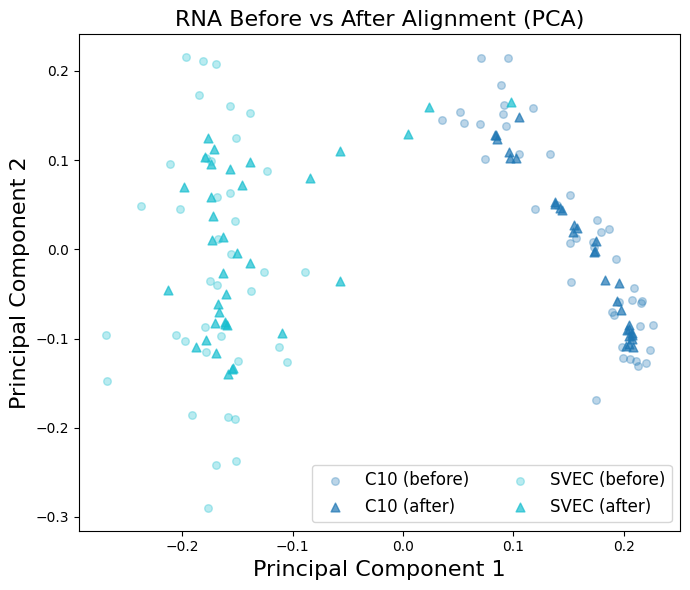

In [57]:
#Original RNA matrix
Xrna = rna_mtx
#Aligned RNA (after AGW alignment into protein space)
Yrna = aligned_rna_in_prot_space.detach().cpu().numpy()

#Concatenate before- and after-alignment RNA for joint PCA projection
concatenated = np.concatenate((Xrna, Yrna), axis=0)
concatenated_pc = rna_pca.transform(concatenated)

#Split PCA coordinates
Xrna_pc = concatenated_pc[:Xrna.shape[0], :]
Yrna_pc = concatenated_pc[Xrna.shape[0]:, :]

#Labels
x_labels = np.array(rna['cell_type'])
y_labels = label_array  # aligned RNA labels (ensure same order as Yrna)
all_labels = np.hstack((x_labels, y_labels))

#Transparency
alphas = np.hstack((
    np.ones(len(x_labels)) * 0.3,   # before-alignment
    np.ones(len(y_labels)) * 0.7    # after-alignment
))

#Combine PCA coords for masking
all_coords = np.vstack((Xrna_pc, Yrna_pc))

#Unique cell types
unique_labels = np.unique(x_labels)

#Assign colours using a colourmap
color_map = cm.get_cmap('tab10', len(unique_labels))
label_to_color = {label: color_map(i) for i, label in enumerate(unique_labels)}

plt.figure(figsize=(7, 6))
for i, label in enumerate(unique_labels):
    mask = (all_labels == label)
    
    #Before-alignment points
    mask_before = mask.copy()
    mask_before[len(x_labels):] = False
    plt.scatter(all_coords[mask_before, 0], all_coords[mask_before, 1], s=30, alpha=0.3, color=label_to_color[label], marker='o',
                label=f'{label} (before)')
    
    #After-alignment points
    mask_after = mask.copy()
    mask_after[:len(x_labels)] = False
    plt.scatter(all_coords[mask_after, 0], all_coords[mask_after, 1], s=40, alpha=0.7, color=label_to_color[label], marker='^',
                label=f'{label} (after)')

plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('RNA Before vs After Alignment (PCA)', fontsize=16)
plt.legend(loc='best', fontsize=12, ncol=2)
plt.tight_layout()

#Save as SVG to OUT_DIR
os.makedirs(OUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUT_DIR, 'RNA_before_after_alignment_PCA.svg'), format='svg')

plt.show()

C:\Users\49152\AppData\Local\Temp\ipykernel_13468\2293922080.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(unique_labels))


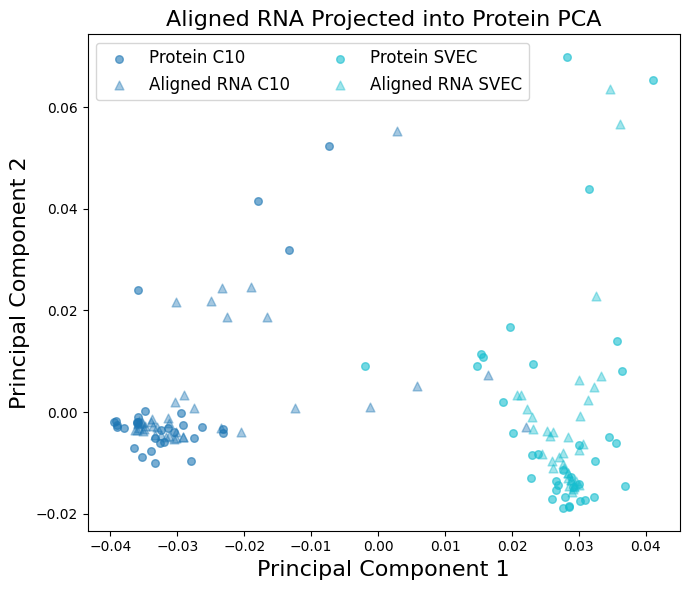

In [59]:
#RNA aligned into protein space
aligned_rna = get_barycentre(prot_mtx, pi_samp, device=device)
aligned_rna_np = aligned_rna.detach().cpu().numpy()

#Project aligned RNA into protein PCA space
aligned_rna_pca = prot_pca.transform(aligned_rna_np)

#Prepare labels
rna_labels = np.array(rna['cell_type'])
prot_labels = np.array(prot['cell_type'])
unique_labels = np.unique(rna_labels)

#Combine coordinates for masking
all_coords = np.vstack((prot_2Dpca, aligned_rna_pca))
all_labels = np.hstack((prot_labels, rna_labels))

#Define transparency
alphas = np.hstack((
    np.ones(len(prot_labels)) * 0.6,  # protein cells
    np.ones(len(rna_labels)) * 0.4    # aligned RNA
))

#Assign colors automatically
color_map = cm.get_cmap('tab10', len(unique_labels))
label_to_color = {label: color_map(i) for i, label in enumerate(unique_labels)}

plt.figure(figsize=(7,6))

for label in unique_labels:
    #Protein mask
    mask_prot = np.zeros(len(all_labels), dtype=bool)
    mask_prot[:len(prot_labels)] = (prot_labels == label)
    
    #RNA mask
    mask_rna = np.zeros(len(all_labels), dtype=bool)
    mask_rna[len(prot_labels):] = (rna_labels == label)
    
    #Plot protein cells
    plt.scatter(all_coords[mask_prot, 0], all_coords[mask_prot, 1], s=30, alpha=0.6, color=label_to_color[label], marker='o', label=f'Protein {label}')
    
    #Plot aligned RNA cells
    plt.scatter(all_coords[mask_rna, 0], all_coords[mask_rna, 1], s=40, alpha=0.4, color=label_to_color[label], marker='^', label=f'Aligned RNA {label}')

plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('Aligned RNA Projected into Protein PCA', fontsize=16)
plt.legend(loc='best', fontsize=12, ncol=2)
plt.tight_layout()

# Save as SVG
plt.savefig(os.path.join(OUT_DIR, 'Aligned_RNA_on_Protein_PCA.svg'), format='svg')
plt.show()

In [169]:
aligned_rna_df = pd.DataFrame(aligned_rna_in_prot_space.cpu().numpy(), index=prot_cells, columns=rna_features).T
aligned_rna_df

05J_C10_A10  05J_C10_A11  05J_C10_A2  05J_C10_A3  05J_C10_A4  \
Crip1             0.045957     0.046234    0.047130    0.039277    0.040229   
Dcn               0.047491     0.051365    0.048303    0.040341    0.042900   
Spp1              0.033465     0.031607    0.034550    0.040147    0.038599   
Lpl               0.043881     0.046306    0.044488    0.035153    0.036915   
Ccl7              0.034073     0.031413    0.034779    0.040817    0.029421   
...                    ...          ...         ...         ...         ...   
Cstf2             0.005224     0.005970    0.003518    0.016094    0.010885   
Acsl1             0.003304     0.004759    0.002942    0.003150    0.004670   
Tlcd3a            0.012379     0.006957    0.012830    0.008200    0.009350   
Elp1              0.007632     0.007240    0.009667    0.002731    0.013106   
9130008F23Rik     0.004332     0.005473    0.004829    0.006976    0.004947   

               05J_C10_A5  05J_C10_A6  05J_C10_A7  05J_C10_A8  05J_C10_A9  \
Crip1            0.041419    0.040762    0.045744    0.041322    0.040354   
Dcn              0.043259    0.042291    0.049354    0.040612    0.042948   
Spp1             0.032330    0.037083    0.031035    0.039347    0.038140   
Lpl              0.035776    0.037841    0.045132    0.037152    0.036682   
Ccl7             0.018123    0.038648    0.032015    0.040869    0.029840   
...                   ...         ...         ...         ...         ...   
Cstf2            0.006064    0.010773    0.006235    0.010799    0.011085   
Acsl1            0.010685    0.001555    0.004820    0.006772    0.004645   
Tlcd3a           0.010091    0.009885    0.010299    0.006785    0.009373   
Elp1             0.009219    0.006152    0.008322    0.004840    0.012637   
9130008F23Rik    0.003884    0.003520    0.005248    0.004462    0.006468   

               ...   07J_SVEC_C4  07J_SVEC_C5  07J_SVEC_C6   07J_SVEC_C8  \
Crip1          ...  2.233917e-07     0.000094     0.000308  4.165712e-07   
Dcn            ...  2.597478e-02     0.030755     0.024483  1.932713e-02   
Spp1           ...  4.018485e-03     0.000988     0.001068  7.325881e-04   
Lpl            ...  1.397613e-02     0.021827     0.012953  7.485996e-03   
Ccl7           ...  2.905579e-02     0.022562     0.019905  1.346622e-02   
...            ...           ...          ...          ...           ...   
Cstf2          ...  1.010549e-02     0.007945     0.007602  1.074329e-02   
Acsl1          ...  3.440666e-03     0.002991     0.004414  1.433382e-03   
Tlcd3a         ...  4.109098e-03     0.006377     0.005981  2.541970e-03   
Elp1           ...  1.263496e-02     0.011982     0.007407  5.103818e-03   
9130008F23Rik  ...  8.103750e-04     0.000431     0.000112  1.007883e-03   

               07J_SVEC_C9   07J_SVEC_D2   07J_SVEC_D3  07J_SVEC_D6  \
Crip1             0.000916  8.327905e-08  3.289147e-09     0.014935   
Dcn               0.033244  2.794529e-02  2.286214e-02     0.027443   
Spp1              0.000324  3.196872e-03  4.544808e-03     0.014330   
Lpl               0.021107  2.532019e-02  1.063774e-02     0.026657   
Ccl7              0.018177  3.553484e-02  2.694765e-02     0.022793   
...                    ...           ...           ...          ...   
Cstf2             0.006143  1.354335e-02  1.025453e-02     0.006162   
Acsl1             0.003006  3.222817e-03  6.681823e-03     0.010874   
Tlcd3a            0.008080  5.019689e-03  8.036703e-03     0.001846   
Elp1              0.009616  5.724970e-03  6.058097e-03     0.010352   
9130008F23Rik     0.000014  3.085450e-03  1.376230e-03     0.000070   

               07J_SVEC_D8  07J_SVEC_D9  
Crip1             0.004128     0.013407  
Dcn               0.023637     0.047733  
Spp1              0.003158     0.013856  
Lpl               0.016930     0.035759  
Ccl7              0.018240     0.035930  
...                    ...          ...  
Cstf2             0.009573     0.014003  
Acsl1             0.006654     0.000967

In [171]:
prot_df_for_mofa = pd.DataFrame(prot_mtx, index=prot_cells, columns=prot_features).T
prot_df_for_mofa

05J_C10_A10  05J_C10_A11  05J_C10_A2  05J_C10_A3  05J_C10_A4  \
Eif2b4      0.024797     0.041739    0.024728    0.042055    0.041678   
Slc38a2     0.027781     0.024083    0.027610    0.047430    0.027836   
Wnk1        0.043066     0.024619    0.041761    0.042355    0.042512   
Krt6a       0.023480     0.031338    0.024045    0.038438    0.030336   
Rpl18       0.037405     0.036971    0.036982    0.036947    0.045992   
...              ...          ...         ...         ...         ...   
Dnajc7      0.029253     0.028930    0.029757    0.029174    0.030188   
Ncaph       0.028421     0.027058    0.028469    0.029062    0.029196   
Psmb3       0.032468     0.033077    0.032706    0.034130    0.031612   
Ndufs2      0.028394     0.029901    0.027788    0.027110    0.029233   
Tkt         0.033470     0.033075    0.033670    0.033207    0.032980   

         05J_C10_A5  05J_C10_A6  05J_C10_A7  05J_C10_A8  05J_C10_A9  ...  \
Eif2b4     0.041521    0.041993    0.024993    0.024572    0.042421  ...   
Slc38a2    0.024604    0.027950    0.025037    0.048115    0.024279  ...   
Wnk1       0.042697    0.043220    0.025819    0.042904    0.042248  ...   
Krt6a      0.025615    0.031014    0.025853    0.042105    0.027472  ...   
Rpl18      0.046889    0.047067    0.037609    0.046722    0.046275  ...   
...             ...         ...         ...         ...         ...  ...   
Dnajc7     0.030450    0.030415    0.029424    0.028940    0.029959  ...   
Ncaph      0.029312    0.029050    0.029160    0.028295    0.028041  ...   
Psmb3      0.032306    0.033700    0.032287    0.032149    0.032620  ...   
Ndufs2     0.026705    0.027766    0.030745    0.030043    0.027478  ...   
Tkt        0.033532    0.033415    0.032985    0.033371    0.032819  ...   

         07J_SVEC_C4  07J_SVEC_C5  07J_SVEC_C6  07J_SVEC_C8  07J_SVEC_C9  \
Eif2b4      0.038871     0.038481     0.038390     0.042948     0.038661   
Slc38a2     0.028967     0.028677     0.028609     0.028982     0.028811   
Wnk1        0.040765     0.040357     0.042495     0.040786     0.043185   
Krt6a       0.031135     0.028844     0.030889     0.030470     0.028593   
Rpl18       0.053187     0.051853     0.051396     0.053776     0.052671   
...              ...          ...          ...          ...          ...   
Dnajc7      0.026822     0.028865     0.028316     0.029761     0.029585   
Ncaph       0.029180     0.029032     0.027834     0.029195     0.029023   
Psmb3       0.033452     0.031961     0.031806     0.032996     0.032801   
Ndufs2      0.029108     0.028238     0.028748     0.025739     0.028952   
Tkt         0.031929     0.032126     0.030882     0.031635     0.032128   

         07J_SVEC_D2  07J_SVEC_D3  07J_SVEC_D6  07J_SVEC_D8  07J_SVEC_D9  
Eif2b4      0.038491     0.041353     0.038711     0.039014     0.038993  
Slc38a2     0.028684     0.028754     0.028849     0.029074     0.029058  
Wnk1        0.027186     0.025983     0.040598     0.040916     0.040894  
Krt6a       0.030753     0.028934     0.032037     0.034282     0.046804  
Rpl18       0.051536     0.052035     0.053463     0.054254     0.051468  
...              ...          ...          ...          ...          ...  
Dnajc7      0.028495     0.028526     0.028065     0.028358     0.029839  
Ncaph       0.027435     0.029104     0.030679     0.029288     0.027686  
Psmb3       0.030429     0.031735     0.032320     0.033254     0.032438  
Ndufs2      0.028824     0.028894     0.028989     0.029216     0.029200  
Tkt         0.033025     0.033101     0.031070     0.034394     0.030303  

[1000 rows x 67 columns]

In [173]:
assert list(aligned_rna_df.columns) == list(prot_df_for_mofa.columns), "Column names do not match"

In [62]:
# Keep only features above threshold, use it when necessary
#filtered_rna_df = aligned_rna_df.loc[rna_var > rna_thresh, :]
#filtered_prot_df = prot_df_for_mofa.loc[prot_var > prot_thresh,:]
filtered_rna_df = aligned_rna_df
filtered_prot_df = prot_df_for_mofa
print("Filtered RNA shape:", filtered_rna_df.shape)
print("Filtered Proteomics shape:", filtered_prot_df.shape)

Filtered RNA shape: (2000, 67)
Filtered Proteomics shape: (1000, 67)


In [175]:
aligned_rna_scaled = pd.DataFrame(StandardScaler().fit_transform(aligned_rna_df), index=aligned_rna_df.index,
                                  columns=aligned_rna_df.columns)
aligned_rna_scaled.index.name = "Gene"
aligned_rna_scaled

05J_C10_A10  05J_C10_A11  05J_C10_A2  05J_C10_A3  05J_C10_A4  \
Gene                                                                          
Crip1             2.607569     2.595452    2.687200    1.952358    2.195783   
Dcn               2.736780     3.017849    2.784714    2.042790    2.436701   
Spp1              1.555212     1.391432    1.641129    2.026319    2.048640   
Lpl               2.432657     2.601386    2.467491    1.601982    1.896730   
Ccl7              1.606456     1.375505    1.660218    2.083255    1.220534   
...                    ...          ...         ...         ...         ...   
Cstf2            -0.823837    -0.718896   -0.939159   -0.017572   -0.451908   
Acsl1            -0.985530    -0.818519   -0.987095   -1.117482   -1.012676   
Tlcd3a           -0.221066    -0.637644   -0.164860   -0.688402   -0.590439   
Elp1             -0.620974    -0.614346   -0.427919   -1.153054   -0.251529   
9130008F23Rik    -0.898943    -0.759807   -0.830186   -0.792399   -0.987688   

               05J_C10_A5  05J_C10_A6  05J_C10_A7  05J_C10_A8  05J_C10_A9  \
Gene                                                                        
Crip1            2.323102    2.170535    2.587462    2.134050    2.185342   
Dcn              2.493446    2.302365    2.890651    2.073888    2.416359   
Spp1             1.481681    1.853460    1.352096    1.966709    1.988047   
Lpl              1.800644    1.918840    2.536066    1.780690    1.858172   
Ccl7             0.166417    1.988388    1.434382    2.095664    1.248661   
...                   ...         ...         ...         ...         ...   
Cstf2           -0.949948   -0.414170   -0.730888   -0.452136   -0.422155   
Acsl1           -0.522224   -1.208677   -0.849709   -0.793360   -0.995855   
Tlcd3a          -0.577170   -0.490729   -0.389540   -0.792261   -0.574637   
Elp1            -0.657941   -0.812463   -0.555615   -0.957013   -0.283854   
9130008F23Rik   -1.151793   -1.039309   -0.813766   -0.989073   -0.833479   

               ...  07J_SVEC_C4  07J_SVEC_C5  07J_SVEC_C6  07J_SVEC_C8  \
Gene           ...                                                       
Crip1          ...    -1.722432    -1.522738    -1.608183    -1.231420   
Dcn            ...     1.011892     1.543849     0.934804     0.495786   
Spp1           ...    -1.299432    -1.433316    -1.528220    -1.165987   
Lpl            ...    -0.251197     0.650895    -0.278051    -0.562442   
Ccl7           ...     1.336228     0.724464     0.453292    -0.027997   
...            ...          ...          ...          ...          ...   
Cstf2          ...    -0.658658    -0.737518    -0.840914    -0.271341   
Acsl1          ...    -1.360259    -1.232961    -1.176218    -1.103357   
Tlcd3a         ...    -1.289893    -0.894347    -1.011478    -1.004284   
Elp1           ...    -0.392382    -0.333668    -0.861401    -0.775335   
9130008F23Rik  ...    -1.637148    -1.488986    -1.628831    -1.141384   

               07J_SVEC_C9  07J_SVEC_D2  07J_SVEC_D3  07J_SVEC_D6  \
Gene                                                                
Crip1            -1.402419    -1.418742    -1.367165    -0.157034   
Dcn               1.720969     1.266461     0.777074     1.094870   
Spp1             -1.459544    -1.111569    -0.940908    -0.217617   
Lpl               0.548328     1.014220    -0.369452     1.016156   
Ccl7              0.265321     1.995726     1.160254     0.629426   
...                    ...          ...          ...          ...   
Cstf2            -0.897382    -0.117394    -0.405394    -1.035135   
Acsl1            -1.200433    -1.109075    -0.740477    -0.563513   
Tlcd3a           -0.710227    -0.936417    -0.613403    -1.467108   
Elp1             -0.561852    -0.868648    -0.798977    -0.615693   
9130008F23Rik    -1.489556    -1.122275    -1.238089    -1.644789   

               07J_SVEC_D8  07J_SVEC_D9  
Gene                                     
Crip1            -1.164919    -0.134999 

In [177]:
prot_scaled = pd.DataFrame(StandardScaler().fit_transform(prot_df_for_mofa), index=prot_df_for_mofa.index,
                           columns=prot_df_for_mofa.columns)
prot_scaled.index.name = "Gene"
prot_scaled

05J_C10_A10  05J_C10_A11  05J_C10_A2  05J_C10_A3  05J_C10_A4  \
Gene                                                                    
Eif2b4     -1.610282     2.681572   -1.631273    2.444881    2.448433   
Slc38a2    -0.878145    -1.891817   -0.922348    3.668371   -0.829857   
Wnk1        2.872799    -1.752828    2.557949    2.512998    2.645827   
Krt6a      -1.933559    -0.012399   -1.799183    1.621293   -0.237798   
Rpl18       1.483545     1.446553    1.382609    1.281817    3.470063   
...              ...          ...         ...         ...         ...   
Dnajc7     -0.516893    -0.636258   -0.394213   -0.487717   -0.272726   
Ncaph      -0.720896    -1.121157   -0.711207   -0.513118   -0.507596   
Psmb3       0.272015     0.437861    0.330848    0.640558    0.064448   
Ndufs2     -0.727621    -0.384640   -0.878666   -0.957634   -0.498997   
Tkt         0.517977     0.437482    0.568151    0.430547    0.388383   

         05J_C10_A5  05J_C10_A6  05J_C10_A7  05J_C10_A8  05J_C10_A9  ...  \
Gene                                                                 ...   
Eif2b4     2.408341    2.501590   -1.554178   -1.512035    2.680232  ...   
Slc38a2   -1.592978   -0.794318   -1.543353    3.773404   -1.712586  ...   
Wnk1       2.686531    2.789383   -1.352273    2.603479    2.638510  ...   
Krt6a     -1.353779   -0.075241   -1.344033    2.424169   -0.939388  ...   
Rpl18      3.678067    3.692327    1.526880    3.460644    3.613465  ...   
...             ...         ...         ...         ...         ...  ...   
Dnajc7    -0.210337   -0.215776   -0.471993   -0.531448   -0.337217  ...   
Ncaph     -0.479406   -0.536115   -0.536404   -0.676386   -0.801722  ...   
Psmb3      0.228731    0.555256    0.227110    0.189013    0.306976  ...   
Ndufs2    -1.096075   -0.837397   -0.149368   -0.283840   -0.937997  ...   
Tkt        0.518831    0.488290    0.397663    0.463231    0.355243  ...   

         07J_SVEC_C4  07J_SVEC_C5  07J_SVEC_C6  07J_SVEC_C8  07J_SVEC_C9  \
Gene                                                                       
Eif2b4      1.786011     1.652319     1.617888     2.938245     1.724051   
Slc38a2    -0.562892    -0.611407    -0.620317    -0.608023    -0.594304   
Wnk1        2.235393     2.085404     2.557424     2.389332     2.788739   
Krt6a      -0.048738    -0.572853    -0.098582    -0.230140    -0.645695   
Rpl18       5.181568     4.739882     4.594311     5.687593     5.021511   
...              ...          ...          ...          ...          ...   
Dnajc7     -1.071655    -0.567885    -0.687317    -0.410314    -0.412127   
Ncaph      -0.512408    -0.529275    -0.797505    -0.553947    -0.544477   
Psmb3       0.500762     0.146824     0.111244     0.411168     0.344822   
Ndufs2     -0.529386    -0.712640    -0.588390    -1.431385    -0.561235   
Tkt         0.139642     0.184964    -0.100184     0.065699     0.186409   

         07J_SVEC_D2  07J_SVEC_D3  07J_SVEC_D6  07J_SVEC_D8  07J_SVEC_D9  
Gene                                                                      
Eif2b4      1.634269     2.318253     1.942849     2.011917     1.909923  
Slc38a2    -0.599651    -0.594611    -0.677261    -0.612830    -0.579149  
Wnk1       -0.940976    -1.235224     2.444117     2.514071     2.386121  
Krt6a      -0.128473    -0.553017     0.169688     0.762236     3.867014  
Rpl18       4.605875     4.788097     5.861522     6.035886     5.035480  
...              ...          ...          ...          ...          ...  
Dnajc7     -0.642633    -0.647244    -0.885513    -0.801979    -0.383556  
Ncaph      -0.884231    -0.513608    -0.191026    -0.556417    -0.922944  
Psmb3      -0.202195     0.094632     0.244835     0.490895     0.267700  
Ndufs2     -0.567786    -0.562191    -0.639887    -0.575389    -0.543644  
Tkt         0.389148     0.410414    -0.087035     0.791759    -0.267331  

[1000 rows x 67 columns]

In [65]:
# RNA view
aligned_rna_scaled.to_csv(os.path.join(OUT_DIR, "RNA_view.csv"))

# Proteomics view
prot_scaled.to_csv(os.path.join(OUT_DIR, "Proteomics_view.csv"))